# Predicting Ski Resort Lift Ticket Prices
### By Group 28

## Introduction

* provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
* clearly state the question you tried to answer with your project
* identify and describe the dataset that was used to answer the question

## Methods & Results

* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
* your report should include code which:
  - loads data from the original source on the web 
  - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
  - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  - performs the data analysis
  - creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

### Attaching Libraries

In [2]:
# Run First
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ recipes      1.0.1     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::st

### Reading and Cleaning Data

In [3]:
# Reading the Data
url <- "https://raw.githubusercontent.com/alextdart/dsci100-group28-2022wt2/main/European_Ski_Resorts.csv"
raw_data <- read_csv(url, show_col_types = FALSE)

# Removing Unneeded Columns (Resort Name and Row Number)
ski_data <- raw_data |>
    select(HighestPoint:SnowCannons)

### Exploratory Data Analysis

In [4]:
# Summary
summary(ski_data)

  HighestPoint   LowestPoint     DayPassPriceAdult BeginnerSlope   
 Min.   :   0   Min.   :   0.0   Min.   : 0.00     Min.   :  0.00  
 1st Qu.:1550   1st Qu.: 779.2   1st Qu.:34.00     1st Qu.:  8.00  
 Median :2104   Median :1050.0   Median :42.00     Median : 19.00  
 Mean   :2052   Mean   :1055.1   Mean   :40.78     Mean   : 35.87  
 3rd Qu.:2568   3rd Qu.:1350.0   3rd Qu.:49.00     3rd Qu.: 40.00  
 Max.   :3899   Max.   :2180.0   Max.   :81.00     Max.   :312.00  
 IntermediateSlope DifficultSlope     TotalSlope      Snowparks        
 Min.   :  0.00    Min.   :  0.00   Min.   :  0.00   Length:376        
 1st Qu.:  9.00    1st Qu.:  2.00   1st Qu.: 25.00   Class :character  
 Median : 22.00    Median :  5.00   Median : 48.00   Mode  :character  
 Mean   : 38.35    Mean   : 11.78   Mean   : 86.26                     
 3rd Qu.: 42.25    3rd Qu.: 13.00   3rd Qu.:100.00                     
 Max.   :239.00    Max.   :103.00   Max.   :600.00                     
   NightSki         

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



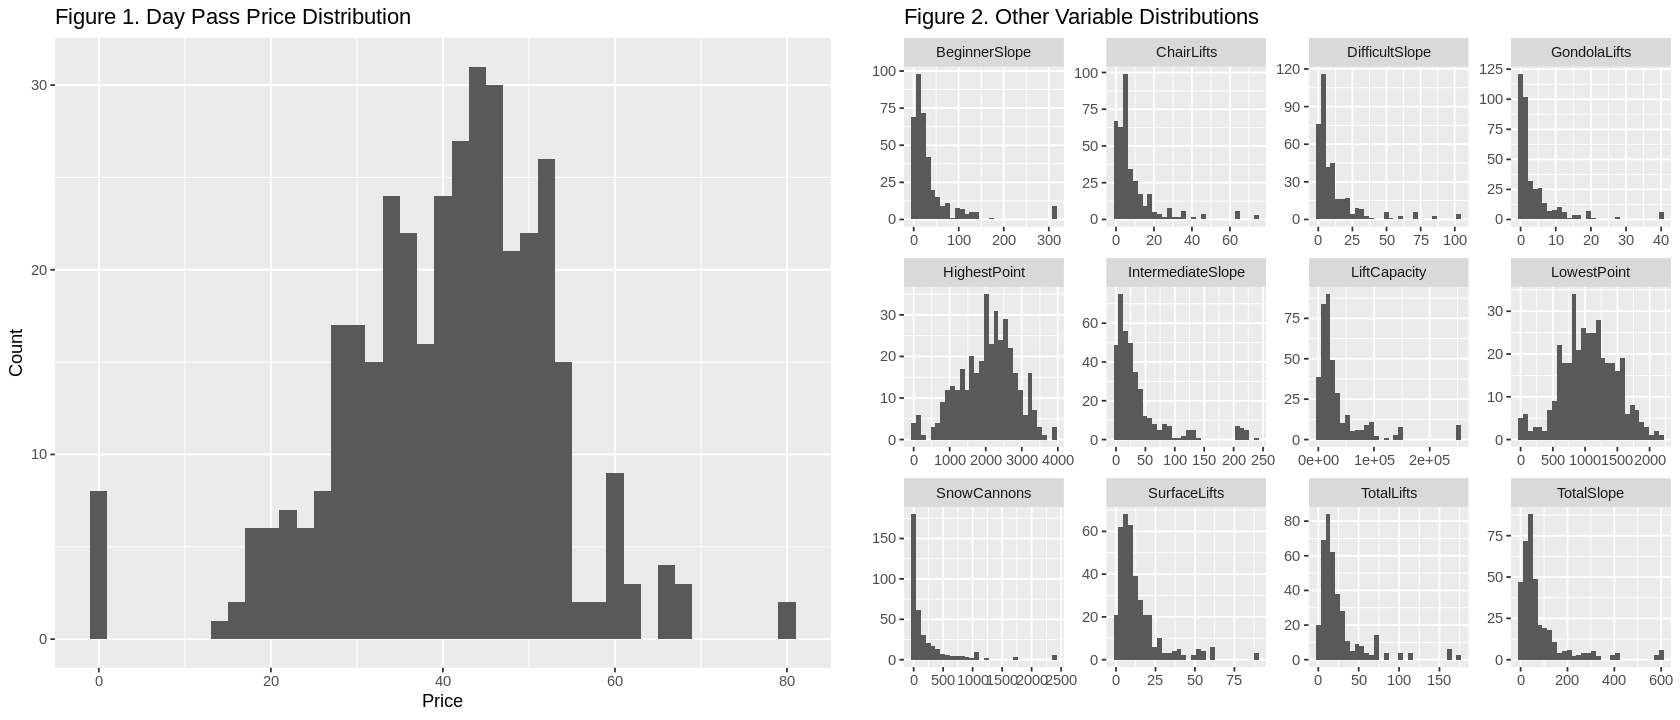

In [5]:
# Response Variable Distribution Chart
daypass_dist <- ski_data |>
    ggplot(aes(x = DayPassPriceAdult)) +
    geom_histogram(binwidth = 2) +
    labs(title = "Figure 1. Day Pass Price Distribution", x = "Price", y = "Count")

# Other Variable Distributions Chart
other_eda_dists <- ski_data |>
    keep(is.numeric) |>
    select(-DayPassPriceAdult) |>
    gather() |>
    ggplot(aes(value)) +
    facet_wrap(~ key, scales = "free") +
    geom_histogram() +
    labs(title = "Figure 2. Other Variable Distributions", x = "", y = "")

options(repr.plot.width = 14, repr.plot.height = 6)
plot_grid(daypass_dist, other_eda_dists, ncol = 2)

In [7]:
# Correlation with Day Pass Price of Major Variables of Interest
ski_correlation <- ski_data |>
    select(DayPassPriceAdult, HighestPoint, LowestPoint,  
           TotalSlope, TotalLifts, LiftCapacity, SnowCannons) |>
    cor() |>
    round(3) 
    
ski_correlation[1,2:7]

HighestPoint  LowestPoint   TotalSlope   TotalLifts LiftCapacity  SnowCannons 
       0.533        0.202        0.509        0.463        0.463        0.391

### Data Analysis

In [8]:
#todo: code this
set.seed(5555)

ski_data_numeric <- ski_data |>
                 keep(is.numeric)

ski_split <- initial_split(ski_data_numeric, prop = 0.70, strata = DayPassPriceAdult)  
ski_train <- training(ski_split)
ski_test <- testing(ski_split)

gridvals <- tibble(neighbors = seq(1, 10, 1))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression")

ski_vfold <- vfold_cv(ski_train, v = 5, strata = DayPassPriceAdult)

ski_recipe <- recipe(DayPassPriceAdult ~ ., data = ski_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

ski_fit <- workflow() |> 
           add_recipe(ski_recipe) |>
           add_model(knn_spec) |>
           tune_grid(resamples = ski_vfold, grid = gridvals) |>
           collect_metrics() |>
           filter(.metric == "rmse") |>
           arrange(mean) |>
           filter(mean == min(mean))

ski_k <- ski_fit |>
         pull(neighbors)

ski_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = ski_k) |>
            set_engine("kknn") |>
            set_mode("regression")

### Data Analysis Visualization

In [51]:
#todo: code this

## Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

todo: write this

## References

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
* Make sure to cite the source of your data as well.

todo: write this